In [97]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from tqdm.auto import tqdm

In [98]:
X, y = make_moons(noise=0.6, n_samples=5000, random_state=42); 
print("X,Y Shape: ", X.shape, y.shape)

y[y == 0] = -1
print(y)

X,Y Shape:  (5000, 2) (5000,)
[-1  1  1 ...  1  1 -1]


In [99]:
def test_train_split(X, y, ratio=0.2):
    rounded_train_size = int(len(X) * (1-ratio)); 
    train_X, train_y = X[:rounded_train_size], y[:rounded_train_size]; 
    test_X, test_y = X[rounded_train_size:], y[rounded_train_size:]; 

    return (train_X, train_y), (test_X, test_y);


(train_X, train_y), (test_X, test_y) = test_train_split(X, y);
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# log the shapes
print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_y shape: {test_y.shape}")

train_X shape: (4000, 2)
train_y shape: (4000, 1)
test_X shape: (1000, 2)
test_y shape: (1000, 1)


In [100]:
# Define all the hyperparameters
lamda = 0.01; # regularization parameter
lr = 1e-3 # learning rate
losses = [] # to store the loss values
gamma = 0.5 # for scaling (length function of RBF)""


# alpha: global hyperparmeter for kernel scaling factors (this is literally a hack)
alpha = np.random.randn(len(train_X), 1)
print(alpha.shape, alpha[:5], "...")

(4000, 1) [[-0.45516007]
 [ 0.56756975]
 [-0.61011283]
 [ 1.02268898]
 [-0.52901207]] ...


In [101]:
"""
Kernel Explaination:
    We have Eqn Y = Xw + b
    We convert RHS into kernelized form with K_x such that K_x = K (X, X(i)
        so evidently we sum it over all such values
    Y = \sum alpha_i K(X, X(i)) + b
"""

def kernel(X_1, X_2, gamma=gamma): # Define the kernel function
    K = np.zeros((len(X_1), len(X_2))); 

    # Inefficient for loop way: but it works garunteed
    # for i in range(len(X)):
    #     for j in range(len(X)):
    #         K[i, j] = RBF_kernel(X[i], X[j])

    # numpy way: for RBF
    distances = np.sum(X_1**2, axis=1).reshape(-1, 1) + np.sum(X_2**2, axis=1) - 2 * np.dot(X_1, X_2.T); 

    return np.exp(-gamma * distances); 

In [102]:
def predict(X, alpha=alpha): # Make a prediction 
    y_pred = np.dot(kernel(X, X), alpha) 
    y_pred = np.array(y_pred.reshape(-1), dtype=np.int64); 

    return y_pred

def predict_test(test_X, train_X=train_X):
    y_pred = np.dot(kernel(test_X, train_X), alpha) 
    return_pred = np.ones(y_pred.shape)
    return_pred[y_pred < 0] = -1

    return return_pred

In [103]:
# Calculate the loss ref: https://stats.stackexchange.com/questions/74499/what-is-the-loss-function-of-hard-margin-svm
def calculate_svm_loss(y_pred, y, lamda=lamda):
    # regularization loss:
    a = lamda * np.sum(np.square(alpha))


    # Misclassification loss:
    y_pred = y_pred.reshape(-1, 1); 
    b = np.sum(np.maximum(0, 1 - y * y_pred))

    # 1XN Nx1 = 1X1"
    # Nx1, Nx1 => Nx1 => max(0, NX1)
    return a + b; # loss = \lambda ||\alpha^||2 + \sum max(0, 1 - y_i * y_pred_i) 

In [104]:
def calculate_gradients(X, y, y_pred, alpha):
    # d(\sum_i (1 - y_i(alpha_i k(x, x_i)))) / d(alpha_i) = -y_i * k(x, x_i) if y_i(alpha_i k(x, x_i)) < 0
    temp_diff = y * np.sum(kernel(X, X), axis=1).reshape(-1, 1)

    # For correct preds set temp_differential to 0
    # since if pred is correct we need to only regu11 and not penalize
    y_pred = y_pred.reshape(-1, 1)
    temp_diff[y * y_pred > 0] = 0

    # dalpha_l = lamda * 2 * alpha + np.dot(y[pred_vector].T, kernel(X, X)).reshape(-1, 1)
    # 2nd term: such that y_pred = \alpha K
    # This is dL/dAlpha
    return lamda * 2 * alpha - temp_diff

In [105]:
def update_weights(dalpha_l, alpha):
    alpha -= lr * dalpha_l
    return alpha

In [106]:
EPOCHS = 100
losses = []

for epoch in tqdm(range(EPOCHS)): 
    y_pred = predict(train_X, alpha) # make a prediction
    
    loss = calculate_svm_loss(y_pred, train_y) # calculate the loss

    dalpha_l = calculate_gradients(train_X, train_y, y_pred, alpha) # calculate the backprop gradients
    alpha = update_weights(dalpha_l, alpha) # update the weights

    losses.append(loss) # some bookkeeping

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 55462.850594368174 ()
Loss: 1179318.2825146385 ()
Loss: 528467.8582449629 ()
Loss: 329513.198016055 ()
Loss: 254719.89426919408 ()
Loss: 377091.1603708647 ()
Loss: 855201.3174078821 ()
Loss: 663952.3302689408 ()
Loss: 419263.64301616047 ()
Loss: 299970.7482692829 ()
Loss: 271972.14694830985 ()
Loss: 442185.2087799966 ()
Loss: 874293.5875616658 ()
Loss: 541080.9277689619 ()
Loss: 359765.499981399 ()
Loss: 271429.2415768254 ()
Loss: 295171.1823523076 ()
Loss: 626508.301598129 ()
Loss: 856895.9591942503 ()
Loss: 493808.8009670544 ()
Loss: 325069.0347067789 ()
Loss: 243496.91033282783 ()
Loss: 235973.27633117253 ()
Loss: 651021.9889835333 ()
Loss: 851907.2183867499 ()
Loss: 602575.5430793087 ()
Loss: 361574.0090639812 ()
Loss: 265141.2278455437 ()
Loss: 212840.06018869812 ()
Loss: 388367.62249865104 ()
Loss: 1043836.2990517222 ()
Loss: 594073.265673203 ()
Loss: 394289.89589808823 ()
Loss: 294817.7920511929 ()
Loss: 273380.44582697836 ()
Loss: 526468.8609100871 ()
Loss: 946281.9433350

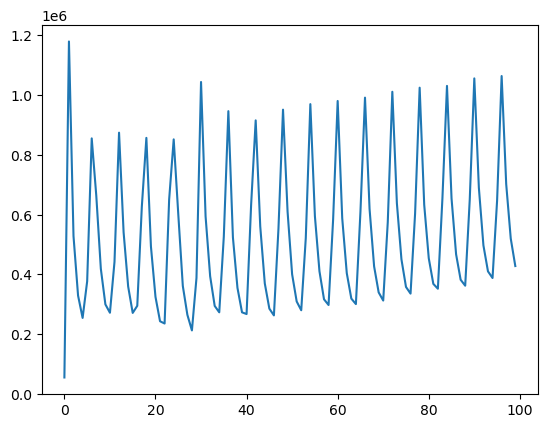

In [109]:
plt.plot(losses)

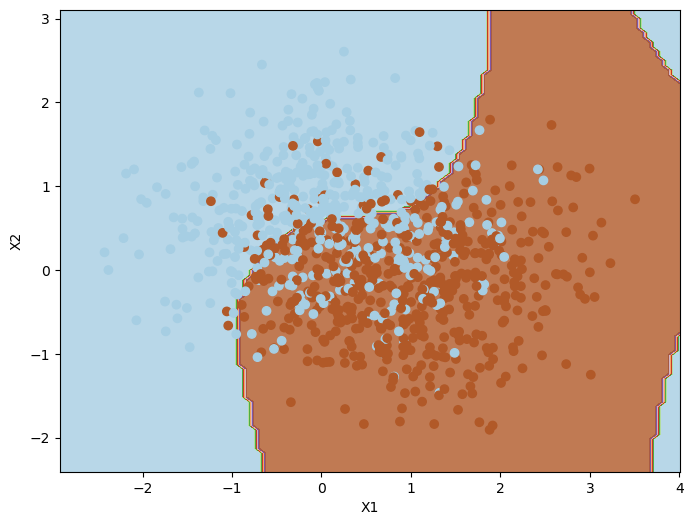

0.781


In [110]:
# Plot the decision boundary
def plot_decision_boundary(X, y):
    plt.figure(figsize=(8, 6))
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = predict_test(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

def accuracy(X, y):
    y_pred = predict_test(X)
    accuracy = np.mean(y_pred == y)
    return accuracy

plot_decision_boundary(test_X, test_y)
print(accuracy(test_X, test_y))